### Part A. Bayesian Cubic Spline

The file ESM2023 20230428 5m.csv contains intra-day trading data for the SP500 E-mini futures
(June 2023 expiry) for the 4/28/23 trading session. Each time-stamped row is associated with
a 5-minute interval. For each row in the data, the time-stamp represents the beginning of each
5-minute interval and the Close value represents the futures price at the end of the interval.

Please design and fit a cubic spline of the time series of Close using the Bayesian approach.

Please use 9 strategically placed internal knots, which implies 13 basis functions (including the
intercept) or 12 basis functions (excluding the intercept).

Finance theory and empirical evidence suggests that it’s most appropriate to model Close as from
a log-normal distribution:

* Close ∼LogNormal(mean parameter = a + BTw,sd parameter = σ)

where a is the intercept, B are the basis functions and w are the coefficients in the cubic spline
regression.

Please let your code plot out the final fit, including the 90% credible interval for the fitted curve
for Close, as well as the knot locations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import arviz as az
import pymc as pm
from patsy import dmatrix

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

In [2]:
#read data
data = pd.read_csv("ESM2023_20230428_5m.csv")

#datetime type can't be knots
data['Time'] = pd.to_datetime(data['DateTime'], format='%Y-%m-%d %H:%M:%S')
#convert to numerical representation
data['Time_Index'] = list(range(0, data.shape[0]*5, 5))

#drop unnecessary columns
data.drop([data.columns[0], data.columns[1]], axis=1, inplace=True)
data.head(3)

,Open,High,Low,Close,Volume,Count,Time,Time_Index
0,4151.00,4153.00,4148.25,4151.00,3035,921,2023-04-27 18:00:00,0
1,4151.00,4152.25,4150.25,4151.75,1872,507,2023-04-27 18:05:00,5
2,4151.75,4152.25,4149.50,4149.75,1301,350,2023-04-27 18:10:00,10


In [3]:
#9 knots
num_knots = 11
cs_knots = np.quantile(data['Time_Index'], np.linspace(0, 1, num_knots))[1:-1]
cs_knots

cs_basis = dmatrix('bs(x, knots = cs_knots, degree = 3, include_intercept = False)', 
                   {'x':data['Time_Index'].values}, return_type = 'dataframe')
cs_basis.head(3)


array([ 137.5,  275. ,  412.5,  550. ,  687.5,  825. ,  962.5, 1100. ,
       1237.5])

,Intercept,"bs(x, knots=cs_knots, degree=3, include_intercept=False)[0]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[1]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[2]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[3]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[4]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[5]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[6]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[7]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[8]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[9]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[10]","bs(x, knots=cs_knots, degree=3, include_intercept=False)[11]"
0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.103225,0.001939,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.195053,0.007581,0.000064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


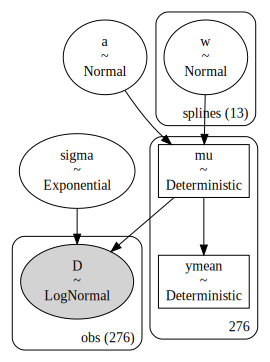

In [4]:
coords = {"splines": np.arange(cs_basis.shape[1])}
with pm.Model(coords=coords) as model:
    a = pm.Normal("a", 0, 1)
    w = pm.Normal("w", mu=0, sigma=1,  dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(cs_basis, order="F"), w))
    ymean = pm.Deterministic('ymean',mu)
    sigma = pm.Exponential("sigma", 1)
    
    D = pm.LogNormal("D", mu=mu, sigma=sigma, observed=data.Close, dims="obs",shape=mu.shape)
    
pm.model_to_graphviz(model)    

In [5]:
#get samples from the posterior using the step methods
with model:
    idata = pm.sample(draws = 5000, tune = 5000, chains = 4, random_seed = None)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
# az.summary(idata, var_names = ['a', 'w', 'sigma'], round_to=2)

In [ ]:
fig = plt.figure(figsize=(12, 8))

#plot dp
plt.scatter(data["Time"], data["Close"], edgecolors='lightblue');

ymean = idata.posterior.ymean
#plot mean
mean = ymean.mean(dim=["chain", "draw"])
plt.plot(data["Time"],np.exp(mean), color="r");

#plot ci
az.plot_hdi(data["Time"], np.exp(ymean), 
            hdi_prob=0.90, color="red", smooth = False)

#plot knots
knots = np.quantile(data['Time'], np.linspace(0, 1, 11))[1:-1]
for i in range(9):
    plt.axvline(x = knots[i], color = 'lightblue');
plt.title("Bayesian Cubic Spline");
plt.xlabel("MM-DD-HH");
plt.ylabel("Close");